# Train Log 20181130

## Results
```

```

## Trained model
* [Download link]()

## Evaluation
* Incorrect sample
![results]()

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import time , datetime

sys.path.append( os.path.abspath('../../../Dataset/scripts'))
from utils import *

sys.path.append( os.path.abspath('../../model') )
from train import *
import model_out_5 as MODEL

In [2]:
""" Path """
data_train_path = os.path.abspath('../../../Dataset_ver2/dataset/db_v8_aug_20181129_ndb_v2_20181020/train.h5')
data_vali_path = os.path.abspath('../../../Dataset_ver2/dataset/db_v8_aug_20181129_ndb_v2_20181020/vali.h5')


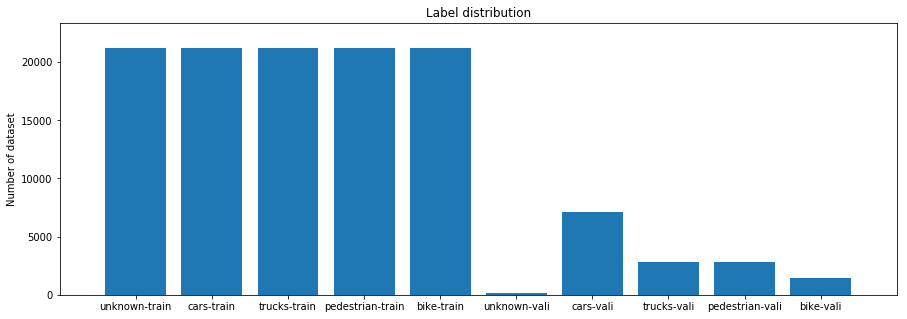

In [3]:
""" Load dataset"""

data = []
label = []

data_train, label_train = load_h5(data_train_path)
data_vali, label_vali = load_h5(data_vali_path)

data.append(data_train)
data.append(data_vali)
label.append(label_train)
label.append(label_vali)

""" Data statistics """

label_list = [0,1,2,3,4]

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(label[i] == label_list[j]))

x_name=('unknown-train', 'cars-train', 'trucks-train', 'pedestrian-train', 'bike-train',
        'unknown-vali', 'cars-vali', 'trucks-vali', 'pedestrian-vali', 'bike-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [4]:
""" Path """
log_path = os.path.abspath('./train_log_20181130.txt')

model_save_path = os.path.abspath('./model')
if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)

""" Parameters """
GPU_INDEX = 0
NUM_POINT = 1024
NUM_CLASSES = 5

BN_INIT_DECAY = 0.5
BN_DECAY_DECAY_RATE = 0.5
BN_DECAY_DECAY_STEP = float(200000)
BN_DECAY_CLIP = 0.99
DECAY_STEP = BN_DECAY_DECAY_STEP
DECAY_RATE = BN_DECAY_DECAY_RATE

BATCH_SIZE = 50

MOMENTUM = 0.9

BASE_LEARNING_RATE = 0.001

OPTIMIZER = 'adam'

MAX_EPOCH = 10

""" log file """
LOG_FOUT = open(log_path, 'w')

def log_string(out_str):
    out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
    LOG_FOUT.write(out_str+'\n')
    LOG_FOUT.flush()
    print(out_str)
    
    
def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
                        BASE_LEARNING_RATE,  # Base learning rate.
                        batch * BATCH_SIZE,  # Current index into the dataset.
                        DECAY_STEP,          # Decay step.
                        DECAY_RATE,          # Decay rate.
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
    return learning_rate        

def get_bn_decay(batch):
    bn_momentum = tf.train.exponential_decay(
                      BN_INIT_DECAY,
                      batch * BATCH_SIZE,
                      BN_DECAY_DECAY_STEP,
                      BN_DECAY_DECAY_RATE,
                      staircase=True)
    bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
    return bn_decay

""" load traing model """
with tf.Graph().as_default():
    with tf.device('/gpu:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())
        print(is_training_pl)

        # Note the global_step=batch parameter to minimize. 
        # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
        batch = tf.Variable(0)
        bn_decay = get_bn_decay(batch)
        tf.summary.scalar('bn_decay', bn_decay)

        # Get model and loss 
        pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
        loss = MODEL.get_loss(pred, labels_pl, end_points)
        tf.summary.scalar('loss', loss)

        correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
        accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
        tf.summary.scalar('accuracy', accuracy)

        # Get training operator
        learning_rate = get_learning_rate(batch)
        tf.summary.scalar('learning_rate', learning_rate)
        if OPTIMIZER == 'momentum':
            optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
        elif OPTIMIZER == 'adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss, global_step=batch)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
    sess = tf.Session(config=config)

    # Add summary writers
    #merged = tf.merge_all_summaries()
    merged = tf.summary.merge_all()

    train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
    if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
    os.mkdir(train_writer_path)
        
    test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
    if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
    os.mkdir(test_writer_path)
    
    
    train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
    test_writer = tf.summary.FileWriter(test_writer_path)
    
    
    # Init variables
    init = tf.global_variables_initializer()
    # To fix the bug introduced in TF 0.12.1 as in
    # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
    #sess.run(init)
    sess.run(init, {is_training_pl: True})

    ops = {'pointclouds_pl': pointclouds_pl,
           'labels_pl': labels_pl,
           'is_training_pl': is_training_pl,
           'pred': pred,
           'loss': loss,
           'train_op': train_op,
           'merged': merged,
           'step': batch}
    
            
    for epoch in range(MAX_EPOCH):
        
        ## Training
        log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = True
        
        # Shuffle train files
        train_file_idxs = np.arange(0, data_train.shape[0])
        np.random.shuffle(train_file_idxs)
        
        current_data = data_train[train_file_idxs] 
        current_label = label_train[train_file_idxs]
        current_label.reshape((data_train.shape[0],))
              
        ## Evaluation metric
        total_correct = 0
        total_seen = 0
        loss_sum = 0
        
        total_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
            
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE           

            # Augment batched point clouds by rotation and jittering
            rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
            jittered_data = provider.jitter_point_cloud(rotated_data)
            
            # Reashape
            current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))
            
            feed_dict = {ops['pointclouds_pl']: jittered_data,
                         ops['labels_pl']: current_label_reshape,
                         ops['is_training_pl']: is_training,}
            
            summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            train_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label_reshape)
            total_correct += correct
            total_seen += BATCH_SIZE
            loss_sum += loss_val
            
            for i in range(NUM_CLASSES):
                total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                        
        log_string(  '[Epoch %d] mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            if not float(total_class[i_cls]) == 0:
                log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            if not float(total_detect_class[i_cls]) == 0:
                log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


        ## Evaluation using validation set    
        log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = False
        total_correct = 0
        total_seen = 0
        total_seen_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
        
        # Shuffle validation files
        file_idxs = np.arange(0, data_vali.shape[0])
        np.random.shuffle(file_idxs)
        
        current_data = data_vali[file_idxs]
        current_label = label_vali[file_idxs]
        
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE
            
            # Reashape
            current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))
            
            feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                         ops['labels_pl']: current_label_reshape,
                         ops['is_training_pl']: is_training}
            summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            # test_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label_reshape)
            total_correct += correct
            total_seen += BATCH_SIZE
            
            for i in range(NUM_CLASSES):
                total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                                
        log_string(  '[Epoch %d] vali mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            if not float(total_class[i_cls]) == 0:
                log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            if not float(total_detect_class[i_cls]) == 0:
                log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    
             
 
        # Save the variables to disk.
        if ( epoch + 1 ) % 10 == 0:
            save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
            log_string("Model saved in file: %s" % save_path)
                

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-11-30 21:15:37.040102   Train one epoch   1 /  10


100%|██████████| 2124/2124 [12:37<00:00,  2.80it/s]

2018-11-30 21:28:16.174598  [Epoch 0] mean loss: 0.013721
2018-11-30 21:28:16.175302  [Epoch 0] accuracy: 0.727768
2018-11-30 21:28:16.175936  [Epoch 0] avg class acc: 0.727768
2018-11-30 21:28:16.176585  [Epoch 0] indivisual [0] class recall: 0.953202
2018-11-30 21:28:16.176715  [Epoch 0] indivisual [0] class precision: 0.951410
2018-11-30 21:28:16.177022  [Epoch 0] indivisual [1] class recall: 0.687147
2018-11-30 21:28:16.177237  [Epoch 0] indivisual [1] class precision: 0.630508
2018-11-30 21:28:16.177446  [Epoch 0] indivisual [2] class recall: 0.568691
2018-11-30 21:28:16.177618  [Epoch 0] indivisual [2] class precision: 0.664667
2018-11-30 21:28:16.178137  [Epoch 0] indivisual [3] class recall: 0.695904
2018-11-30 21:28:16.178272  [Epoch 0] indivisual [3] class precision: 0.659130
2018-11-30 21:28:16.178447  [Epoch 0] indivisual [4] class recall: 0.733898
2018-11-30 21:28:16.178907  [Epoch 0] indivisual [4] class precision: 0.736186
2018-11-30 21:28:16.179185   Evaluation one (val


100%|██████████| 287/287 [00:24<00:00, 11.81it/s]

2018-11-30 21:28:40.759437  [Epoch 0] vali mean loss: 0.101546
2018-11-30 21:28:40.760376  [Epoch 0] vali accuracy: 0.921742
2018-11-30 21:28:40.760847  [Epoch 0] vali avg class acc: 0.000000
2018-11-30 21:28:40.761191  [Epoch 0] vali indivisual [1] class recall: 0.960000
2018-11-30 21:28:40.761359  [Epoch 0] vali indivisual [1] class precision: 1.000000
2018-11-30 21:28:40.761586  [Epoch 0] vali indivisual [2] class recall: 0.923077
2018-11-30 21:28:40.762062  [Epoch 0] vali indivisual [2] class precision: 1.000000
2018-11-30 21:28:40.762521  [Epoch 0] vali indivisual [3] class recall: 0.888889
2018-11-30 21:28:40.762676  [Epoch 0] vali indivisual [3] class precision: 0.800000
2018-11-30 21:28:40.762884  [Epoch 0] vali indivisual [4] class recall: 0.666667
2018-11-30 21:28:40.763192  [Epoch 0] vali indivisual [4] class precision: 0.500000
2018-11-30 21:28:40.763335   Train one epoch   2 /  10



100%|██████████| 2124/2124 [12:36<00:00,  2.81it/s]

2018-11-30 21:41:18.989256  [Epoch 1] mean loss: 0.002475
2018-11-30 21:41:18.989825  [Epoch 1] accuracy: 0.959539
2018-11-30 21:41:18.990545  [Epoch 1] avg class acc: 0.959539
2018-11-30 21:41:18.990850  [Epoch 1] indivisual [0] class recall: 0.994209
2018-11-30 21:41:18.991311  [Epoch 1] indivisual [0] class precision: 0.990897
2018-11-30 21:41:18.991481  [Epoch 1] indivisual [1] class recall: 0.948211
2018-11-30 21:41:18.991747  [Epoch 1] indivisual [1] class precision: 0.944077
2018-11-30 21:41:18.991880  [Epoch 1] indivisual [2] class recall: 0.957957
2018-11-30 21:41:18.992549  [Epoch 1] indivisual [2] class precision: 0.953200
2018-11-30 21:41:18.992916  [Epoch 1] indivisual [3] class recall: 0.961017
2018-11-30 21:41:18.993017  [Epoch 1] indivisual [3] class precision: 0.961651
2018-11-30 21:41:18.993286  [Epoch 1] indivisual [4] class recall: 0.936299
2018-11-30 21:41:18.993417  [Epoch 1] indivisual [4] class precision: 0.947722
2018-11-30 21:41:18.993542   Evaluation one (val


100%|██████████| 287/287 [00:24<00:00, 11.82it/s]

2018-11-30 21:41:43.531926  [Epoch 1] vali mean loss: 0.018315
2018-11-30 21:41:43.532807  [Epoch 1] vali accuracy: 0.995331
2018-11-30 21:41:43.533145  [Epoch 1] vali avg class acc: 0.800000
2018-11-30 21:41:43.533598  [Epoch 1] vali indivisual [0] class recall: 1.000000
2018-11-30 21:41:43.534015  [Epoch 1] vali indivisual [0] class precision: 1.000000
2018-11-30 21:41:43.534132  [Epoch 1] vali indivisual [1] class recall: 0.967742
2018-11-30 21:41:43.534416  [Epoch 1] vali indivisual [1] class precision: 1.000000
2018-11-30 21:41:43.534704  [Epoch 1] vali indivisual [2] class recall: 1.000000
2018-11-30 21:41:43.534839  [Epoch 1] vali indivisual [2] class precision: 1.000000
2018-11-30 21:41:43.535088  [Epoch 1] vali indivisual [3] class recall: 1.000000
2018-11-30 21:41:43.535215  [Epoch 1] vali indivisual [3] class precision: 1.000000
2018-11-30 21:41:43.535929  [Epoch 1] vali indivisual [4] class recall: 1.000000
2018-11-30 21:41:43.536294  [Epoch 1] vali indivisual [4] class pre


100%|██████████| 2124/2124 [12:37<00:00,  2.80it/s]

2018-11-30 21:54:22.077642  [Epoch 2] mean loss: 0.000842
2018-11-30 21:54:22.077967  [Epoch 2] accuracy: 0.987345
2018-11-30 21:54:22.078610  [Epoch 2] avg class acc: 0.987345
2018-11-30 21:54:22.078762  [Epoch 2] indivisual [0] class recall: 0.997505
2018-11-30 21:54:22.079026  [Epoch 2] indivisual [0] class precision: 0.996754
2018-11-30 21:54:22.079170  [Epoch 2] indivisual [1] class recall: 0.983004
2018-11-30 21:54:22.079913  [Epoch 2] indivisual [1] class precision: 0.983467
2018-11-30 21:54:22.080056  [Epoch 2] indivisual [2] class recall: 0.986770
2018-11-30 21:54:22.080303  [Epoch 2] indivisual [2] class precision: 0.985193
2018-11-30 21:54:22.080432  [Epoch 2] indivisual [3] class recall: 0.989407
2018-11-30 21:54:22.081081  [Epoch 2] indivisual [3] class precision: 0.988476
2018-11-30 21:54:22.081440  [Epoch 2] indivisual [4] class recall: 0.980038
2018-11-30 21:54:22.081543  [Epoch 2] indivisual [4] class precision: 0.982814
2018-11-30 21:54:22.081801   Evaluation one (val


100%|██████████| 287/287 [00:24<00:00, 11.87it/s]

2018-11-30 21:54:46.517791  [Epoch 2] vali mean loss: 0.006228
2018-11-30 21:54:46.518365  [Epoch 2] vali accuracy: 0.997143
2018-11-30 21:54:46.518681  [Epoch 2] vali avg class acc: 1.000000
2018-11-30 21:54:46.518993  [Epoch 2] vali indivisual [0] class recall: 1.000000
2018-11-30 21:54:46.519793  [Epoch 2] vali indivisual [0] class precision: 1.000000
2018-11-30 21:54:46.520162  [Epoch 2] vali indivisual [1] class recall: 1.000000
2018-11-30 21:54:46.520262  [Epoch 2] vali indivisual [1] class precision: 1.000000
2018-11-30 21:54:46.520526  [Epoch 2] vali indivisual [2] class recall: 1.000000
2018-11-30 21:54:46.520653  [Epoch 2] vali indivisual [2] class precision: 1.000000
2018-11-30 21:54:46.520749  [Epoch 2] vali indivisual [3] class recall: 1.000000
2018-11-30 21:54:46.520978  [Epoch 2] vali indivisual [3] class precision: 1.000000
2018-11-30 21:54:46.521593  [Epoch 2] vali indivisual [4] class recall: 1.000000
2018-11-30 21:54:46.521721  [Epoch 2] vali indivisual [4] class pre


100%|██████████| 2124/2124 [12:37<00:00,  2.81it/s]

2018-11-30 22:07:24.969064  [Epoch 3] mean loss: 0.000560
2018-11-30 22:07:24.969456  [Epoch 3] accuracy: 0.991780
2018-11-30 22:07:24.970034  [Epoch 3] avg class acc: 0.991780
2018-11-30 22:07:24.970362  [Epoch 3] indivisual [0] class recall: 0.998305
2018-11-30 22:07:24.970580  [Epoch 3] indivisual [0] class precision: 0.997835
2018-11-30 22:07:24.971032  [Epoch 3] indivisual [1] class recall: 0.989030
2018-11-30 22:07:24.971167  [Epoch 3] indivisual [1] class precision: 0.988844
2018-11-30 22:07:24.971414  [Epoch 3] indivisual [2] class recall: 0.990678
2018-11-30 22:07:24.971713  [Epoch 3] indivisual [2] class precision: 0.989793
2018-11-30 22:07:24.972130  [Epoch 3] indivisual [3] class recall: 0.993409
2018-11-30 22:07:24.972259  [Epoch 3] indivisual [3] class precision: 0.993362
2018-11-30 22:07:24.972811  [Epoch 3] indivisual [4] class recall: 0.987476
2018-11-30 22:07:24.972908  [Epoch 3] indivisual [4] class precision: 0.989060
2018-11-30 22:07:24.973162   Evaluation one (val


100%|██████████| 287/287 [00:23<00:00, 12.02it/s]

2018-11-30 22:07:49.109693  [Epoch 3] vali mean loss: 0.004144
2018-11-30 22:07:49.110272  [Epoch 3] vali accuracy: 0.997770
2018-11-30 22:07:49.110652  [Epoch 3] vali avg class acc: 0.800000
2018-11-30 22:07:49.111239  [Epoch 3] vali indivisual [1] class recall: 1.000000
2018-11-30 22:07:49.111443  [Epoch 3] vali indivisual [1] class precision: 1.000000
2018-11-30 22:07:49.111614  [Epoch 3] vali indivisual [2] class recall: 1.000000
2018-11-30 22:07:49.112227  [Epoch 3] vali indivisual [2] class precision: 1.000000
2018-11-30 22:07:49.112596  [Epoch 3] vali indivisual [3] class recall: 1.000000
2018-11-30 22:07:49.112704  [Epoch 3] vali indivisual [3] class precision: 1.000000
2018-11-30 22:07:49.112974  [Epoch 3] vali indivisual [4] class recall: 1.000000
2018-11-30 22:07:49.113106  [Epoch 3] vali indivisual [4] class precision: 1.000000
2018-11-30 22:07:49.113361   Train one epoch   5 /  10



100%|██████████| 2124/2124 [12:36<00:00,  2.81it/s]

2018-11-30 22:20:27.379828  [Epoch 4] mean loss: 0.000251
2018-11-30 22:20:27.380456  [Epoch 4] accuracy: 0.996516
2018-11-30 22:20:27.381090  [Epoch 4] avg class acc: 0.996516
2018-11-30 22:20:27.381417  [Epoch 4] indivisual [0] class recall: 0.999388
2018-11-30 22:20:27.381589  [Epoch 4] indivisual [0] class precision: 0.999106
2018-11-30 22:20:27.381838  [Epoch 4] indivisual [1] class recall: 0.994727
2018-11-30 22:20:27.381960  [Epoch 4] indivisual [1] class precision: 0.994961
2018-11-30 22:20:27.382489  [Epoch 4] indivisual [2] class recall: 0.995763
2018-11-30 22:20:27.382616  [Epoch 4] indivisual [2] class precision: 0.995247
2018-11-30 22:20:27.382784  [Epoch 4] indivisual [3] class recall: 0.997458
2018-11-30 22:20:27.382988  [Epoch 4] indivisual [3] class precision: 0.997739
2018-11-30 22:20:27.383534  [Epoch 4] indivisual [4] class recall: 0.995245
2018-11-30 22:20:27.383794  [Epoch 4] indivisual [4] class precision: 0.995526
2018-11-30 22:20:27.383916   Evaluation one (val


100%|██████████| 287/287 [00:23<00:00, 12.02it/s]

2018-11-30 22:20:51.513761  [Epoch 4] vali mean loss: 0.001858
2018-11-30 22:20:51.514340  [Epoch 4] vali accuracy: 0.997003
2018-11-30 22:20:51.514892  [Epoch 4] vali avg class acc: 1.000000
2018-11-30 22:20:51.515357  [Epoch 4] vali indivisual [0] class recall: 1.000000
2018-11-30 22:20:51.515968  [Epoch 4] vali indivisual [0] class precision: 1.000000
2018-11-30 22:20:51.516380  [Epoch 4] vali indivisual [1] class recall: 1.000000
2018-11-30 22:20:51.516582  [Epoch 4] vali indivisual [1] class precision: 1.000000
2018-11-30 22:20:51.516847  [Epoch 4] vali indivisual [2] class recall: 1.000000
2018-11-30 22:20:51.517431  [Epoch 4] vali indivisual [2] class precision: 1.000000
2018-11-30 22:20:51.517531  [Epoch 4] vali indivisual [3] class recall: 1.000000
2018-11-30 22:20:51.517717  [Epoch 4] vali indivisual [3] class precision: 1.000000
2018-11-30 22:20:51.518063  [Epoch 4] vali indivisual [4] class recall: 1.000000
2018-11-30 22:20:51.518161  [Epoch 4] vali indivisual [4] class pre


100%|██████████| 2124/2124 [12:36<00:00,  2.81it/s]

2018-11-30 22:33:29.686865  [Epoch 5] mean loss: 0.002653
2018-11-30 22:33:29.687754  [Epoch 5] accuracy: 0.992034
2018-11-30 22:33:29.688088  [Epoch 5] avg class acc: 0.992034
2018-11-30 22:33:29.688577  [Epoch 5] indivisual [0] class recall: 0.998023
2018-11-30 22:33:29.688691  [Epoch 5] indivisual [0] class precision: 0.996802
2018-11-30 22:33:29.688935  [Epoch 5] indivisual [1] class recall: 0.990019
2018-11-30 22:33:29.689148  [Epoch 5] indivisual [1] class precision: 0.990065
2018-11-30 22:33:29.689291  [Epoch 5] indivisual [2] class recall: 0.991902
2018-11-30 22:33:29.689422  [Epoch 5] indivisual [2] class precision: 0.990456
2018-11-30 22:33:29.690202  [Epoch 5] indivisual [3] class recall: 0.991902
2018-11-30 22:33:29.690328  [Epoch 5] indivisual [3] class precision: 0.992790
2018-11-30 22:33:29.690447  [Epoch 5] indivisual [4] class recall: 0.988324
2018-11-30 22:33:29.690584  [Epoch 5] indivisual [4] class precision: 0.990049
2018-11-30 22:33:29.691192   Evaluation one (val


100%|██████████| 287/287 [00:23<00:00, 12.02it/s]

2018-11-30 22:33:53.822816  [Epoch 5] vali mean loss: 0.019631
2018-11-30 22:33:53.823347  [Epoch 5] vali accuracy: 0.996167
2018-11-30 22:33:53.823810  [Epoch 5] vali avg class acc: 0.800000
2018-11-30 22:33:53.824449  [Epoch 5] vali indivisual [1] class recall: 1.000000
2018-11-30 22:33:53.824690  [Epoch 5] vali indivisual [1] class precision: 1.000000
2018-11-30 22:33:53.824858  [Epoch 5] vali indivisual [2] class recall: 1.000000
2018-11-30 22:33:53.825113  [Epoch 5] vali indivisual [2] class precision: 1.000000
2018-11-30 22:33:53.825579  [Epoch 5] vali indivisual [3] class recall: 1.000000
2018-11-30 22:33:53.825975  [Epoch 5] vali indivisual [3] class precision: 1.000000
2018-11-30 22:33:53.826198  [Epoch 5] vali indivisual [4] class recall: 1.000000
2018-11-30 22:33:53.826485  [Epoch 5] vali indivisual [4] class precision: 1.000000
2018-11-30 22:33:53.826629   Train one epoch   7 /  10



100%|██████████| 2124/2124 [12:36<00:00,  2.81it/s]

2018-11-30 22:46:32.077167  [Epoch 6] mean loss: 0.000308
2018-11-30 22:46:32.077999  [Epoch 6] accuracy: 0.996064
2018-11-30 22:46:32.078541  [Epoch 6] avg class acc: 0.996064
2018-11-30 22:46:32.078871  [Epoch 6] indivisual [0] class recall: 0.999011
2018-11-30 22:46:32.079050  [Epoch 6] indivisual [0] class precision: 0.998400
2018-11-30 22:46:32.079287  [Epoch 6] indivisual [1] class recall: 0.994492
2018-11-30 22:46:32.079513  [Epoch 6] indivisual [1] class precision: 0.995101
2018-11-30 22:46:32.079977  [Epoch 6] indivisual [2] class recall: 0.995621
2018-11-30 22:46:32.080207  [Epoch 6] indivisual [2] class precision: 0.994685
2018-11-30 22:46:32.080420  [Epoch 6] indivisual [3] class recall: 0.996704
2018-11-30 22:46:32.080546  [Epoch 6] indivisual [3] class precision: 0.996939
2018-11-30 22:46:32.081126  [Epoch 6] indivisual [4] class recall: 0.994492
2018-11-30 22:46:32.081491  [Epoch 6] indivisual [4] class precision: 0.995194
2018-11-30 22:46:32.081631   Evaluation one (val


100%|██████████| 287/287 [00:23<00:00, 12.00it/s]

2018-11-30 22:46:56.273412  [Epoch 6] vali mean loss: 0.002281
2018-11-30 22:46:56.274234  [Epoch 6] vali accuracy: 0.999024
2018-11-30 22:46:56.274578  [Epoch 6] vali avg class acc: 1.000000
2018-11-30 22:46:56.274949  [Epoch 6] vali indivisual [0] class recall: 1.000000
2018-11-30 22:46:56.275127  [Epoch 6] vali indivisual [0] class precision: 1.000000
2018-11-30 22:46:56.275509  [Epoch 6] vali indivisual [1] class recall: 1.000000
2018-11-30 22:46:56.275721  [Epoch 6] vali indivisual [1] class precision: 1.000000
2018-11-30 22:46:56.275868  [Epoch 6] vali indivisual [2] class recall: 1.000000
2018-11-30 22:46:56.275992  [Epoch 6] vali indivisual [2] class precision: 1.000000
2018-11-30 22:46:56.276534  [Epoch 6] vali indivisual [3] class recall: 1.000000
2018-11-30 22:46:56.276662  [Epoch 6] vali indivisual [3] class precision: 1.000000
2018-11-30 22:46:56.276785  [Epoch 6] vali indivisual [4] class recall: 1.000000
2018-11-30 22:46:56.276925  [Epoch 6] vali indivisual [4] class pre


100%|██████████| 2124/2124 [12:37<00:00,  2.80it/s]

2018-11-30 22:59:34.840043  [Epoch 7] mean loss: 0.000177
2018-11-30 22:59:34.840628  [Epoch 7] accuracy: 0.997863
2018-11-30 22:59:34.840987  [Epoch 7] avg class acc: 0.997863
2018-11-30 22:59:34.841661  [Epoch 7] indivisual [0] class recall: 0.999529
2018-11-30 22:59:34.841793  [Epoch 7] indivisual [0] class precision: 0.999153
2018-11-30 22:59:34.842057  [Epoch 7] indivisual [1] class recall: 0.996704
2018-11-30 22:59:34.842189  [Epoch 7] indivisual [1] class precision: 0.997174
2018-11-30 22:59:34.842397  [Epoch 7] indivisual [2] class recall: 0.997646
2018-11-30 22:59:34.842835  [Epoch 7] indivisual [2] class precision: 0.996707
2018-11-30 22:59:34.843026  [Epoch 7] indivisual [3] class recall: 0.998635
2018-11-30 22:59:34.843263  [Epoch 7] indivisual [3] class precision: 0.998400
2018-11-30 22:59:34.843532  [Epoch 7] indivisual [4] class recall: 0.996798
2018-11-30 22:59:34.843775  [Epoch 7] indivisual [4] class precision: 0.997879
2018-11-30 22:59:34.844021   Evaluation one (val


100%|██████████| 287/287 [00:23<00:00, 12.02it/s]

2018-11-30 22:59:58.985124  [Epoch 7] vali mean loss: 0.001308
2018-11-30 22:59:58.985568  [Epoch 7] vali accuracy: 0.998815
2018-11-30 22:59:58.986206  [Epoch 7] vali avg class acc: 0.800000
2018-11-30 22:59:58.986523  [Epoch 7] vali indivisual [1] class recall: 1.000000
2018-11-30 22:59:58.986871  [Epoch 7] vali indivisual [1] class precision: 1.000000
2018-11-30 22:59:58.987094  [Epoch 7] vali indivisual [2] class recall: 1.000000
2018-11-30 22:59:58.987282  [Epoch 7] vali indivisual [2] class precision: 1.000000
2018-11-30 22:59:58.987464  [Epoch 7] vali indivisual [3] class recall: 1.000000
2018-11-30 22:59:58.987959  [Epoch 7] vali indivisual [3] class precision: 1.000000
2018-11-30 22:59:58.988185  [Epoch 7] vali indivisual [4] class recall: 1.000000
2018-11-30 22:59:58.988336  [Epoch 7] vali indivisual [4] class precision: 1.000000
2018-11-30 22:59:58.988465   Train one epoch   9 /  10



100%|██████████| 2124/2124 [12:37<00:00,  2.80it/s]

2018-11-30 23:12:37.816549  [Epoch 8] mean loss: 0.000115
2018-11-30 23:12:37.817458  [Epoch 8] accuracy: 0.998569
2018-11-30 23:12:37.817928  [Epoch 8] avg class acc: 0.998569
2018-11-30 23:12:37.818148  [Epoch 8] indivisual [0] class recall: 0.999812
2018-11-30 23:12:37.818445  [Epoch 8] indivisual [0] class precision: 0.999435
2018-11-30 23:12:37.818726  [Epoch 8] indivisual [1] class recall: 0.997552
2018-11-30 23:12:37.819125  [Epoch 8] indivisual [1] class precision: 0.998492
2018-11-30 23:12:37.819230  [Epoch 8] indivisual [2] class recall: 0.998588
2018-11-30 23:12:37.819507  [Epoch 8] indivisual [2] class precision: 0.997836
2018-11-30 23:12:37.819710  [Epoch 8] indivisual [3] class recall: 0.998635
2018-11-30 23:12:37.819858  [Epoch 8] indivisual [3] class precision: 0.998964
2018-11-30 23:12:37.820099  [Epoch 8] indivisual [4] class recall: 0.998258
2018-11-30 23:12:37.820584  [Epoch 8] indivisual [4] class precision: 0.998117
2018-11-30 23:12:37.820931   Evaluation one (val


100%|██████████| 287/287 [00:23<00:00, 11.97it/s]

2018-11-30 23:13:02.061490  [Epoch 8] vali mean loss: 0.000853
2018-11-30 23:13:02.062098  [Epoch 8] vali accuracy: 0.999303
2018-11-30 23:13:02.062456  [Epoch 8] vali avg class acc: 0.800000
2018-11-30 23:13:02.062635  [Epoch 8] vali indivisual [1] class recall: 1.000000
2018-11-30 23:13:02.062959  [Epoch 8] vali indivisual [1] class precision: 1.000000
2018-11-30 23:13:02.063449  [Epoch 8] vali indivisual [2] class recall: 1.000000
2018-11-30 23:13:02.063723  [Epoch 8] vali indivisual [2] class precision: 1.000000
2018-11-30 23:13:02.063886  [Epoch 8] vali indivisual [3] class recall: 1.000000
2018-11-30 23:13:02.064032  [Epoch 8] vali indivisual [3] class precision: 1.000000
2018-11-30 23:13:02.064490  [Epoch 8] vali indivisual [4] class recall: 1.000000
2018-11-30 23:13:02.064621  [Epoch 8] vali indivisual [4] class precision: 1.000000
2018-11-30 23:13:02.064844   Train one epoch  10 /  10



100%|██████████| 2124/2124 [12:37<00:00,  2.81it/s]

2018-11-30 23:25:40.460558  [Epoch 9] mean loss: 0.000090
2018-11-30 23:25:40.461390  [Epoch 9] accuracy: 0.998795
2018-11-30 23:25:40.461944  [Epoch 9] avg class acc: 0.998795
2018-11-30 23:25:40.462166  [Epoch 9] indivisual [0] class recall: 0.999812
2018-11-30 23:25:40.462464  [Epoch 9] indivisual [0] class precision: 0.999623
2018-11-30 23:25:40.462599  [Epoch 9] indivisual [1] class recall: 0.997976
2018-11-30 23:25:40.462764  [Epoch 9] indivisual [1] class precision: 0.998211
2018-11-30 23:25:40.463320  [Epoch 9] indivisual [2] class recall: 0.998446
2018-11-30 23:25:40.463545  [Epoch 9] indivisual [2] class precision: 0.998070
2018-11-30 23:25:40.463697  [Epoch 9] indivisual [3] class recall: 0.999294
2018-11-30 23:25:40.463865  [Epoch 9] indivisual [3] class precision: 0.999388
2018-11-30 23:25:40.464397  [Epoch 9] indivisual [4] class recall: 0.998446
2018-11-30 23:25:40.464533  [Epoch 9] indivisual [4] class precision: 0.998681
2018-11-30 23:25:40.464714   Evaluation one (val


100%|██████████| 287/287 [00:23<00:00, 12.00it/s]


2018-11-30 23:26:04.657362  [Epoch 9] vali mean loss: 0.000663
2018-11-30 23:26:04.657867  [Epoch 9] vali accuracy: 0.999652
2018-11-30 23:26:04.658352  [Epoch 9] vali avg class acc: 0.800000
2018-11-30 23:26:04.658970  [Epoch 9] vali indivisual [1] class recall: 1.000000
2018-11-30 23:26:04.659085  [Epoch 9] vali indivisual [1] class precision: 1.000000
2018-11-30 23:26:04.659371  [Epoch 9] vali indivisual [2] class recall: 1.000000
2018-11-30 23:26:04.659677  [Epoch 9] vali indivisual [2] class precision: 1.000000
2018-11-30 23:26:04.659803  [Epoch 9] vali indivisual [3] class recall: 1.000000
2018-11-30 23:26:04.660012  [Epoch 9] vali indivisual [3] class precision: 1.000000
2018-11-30 23:26:04.660488  [Epoch 9] vali indivisual [4] class recall: 1.000000
2018-11-30 23:26:04.660748  [Epoch 9] vali indivisual [4] class precision: 1.000000
2018-11-30 23:26:05.511090  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181130_1/model/model.ck